# 语义分块与句子相似度分析实验

本notebook将探索多种语义分块方法，通过向量相似度分析来优化文档分块策略。

## 实验目标
1. 计算句子间的向量相似度
2. 可视化相似度矩阵
3. 实现多种语义分块算法
4. 比较不同分块方法的效果

In [ ]:
# 安装必要的包
# %pip install sentence-transformers matplotlib seaborn numpy pandas scikit-learn plotly networkx

In [1]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import networkx as nx
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# 导入缓存的embedding模型
from cached_embedding_models import get_cached_embedding_model, CachedEmbeddingModelFactory

# 导入spacy句子分割功能
import spacy

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 所有依赖包和模块导入成功")
print("📦 使用缓存embedding模型和spacy句子分割")

✅ 所有依赖包和模块导入成功
📦 使用缓存embedding模型和spacy句子分割


## 1. 数据准备与预处理

In [2]:
# 示例文本数据 - 使用《红楼梦》相关内容作为测试数据
sample_text = """
贾宝玉是《红楼梦》的男主角，性格叛逆，不喜欢读书做官。
林黛玉是贾宝玉的表妹，聪明美丽但体弱多病。
薛宝钗是另一个重要女性角色，端庄贤淑，深受长辈喜爱。
贾家是四大家族之一，曾经显赫一时，但逐渐衰落。
大观园是贾府的后花园，是众多女儿们居住的地方。
贾宝玉与林黛玉青梅竹马，两情相悦。
王熙凤是贾府的管家，精明能干但心机深重。
贾母是贾府的老祖宗，在家族中地位崇高。
《红楼梦》描写了封建社会的兴衰变迁。
小说通过贾府的日常生活展现了当时的社会风貌。
作者曹雪芹通过细腻的笔触刻画了众多人物形象。
这部作品被誉为中国古典小说的巅峰之作。
书中的诗词歌赋体现了深厚的文学功底。
红楼梦不仅是文学作品，也是社会历史的缩影。
宝黛钗三人的感情纠葛是全书的主线之一。
贾宝玉最终看破红尘，选择出家为僧。
"""

print(f"📚 原始文本长度: {len(sample_text)} 字符")
print("💡 注意: 句子分割将在下一个cell中使用spacy模型进行")

# 换成读取红楼梦文本的方式
with open("./红楼梦.txt", "r", encoding="utf-8") as file:
    red_chamber_text = file.read()
print(f"📚 红楼梦文本长度: {len(red_chamber_text)} 字符")

sample_text = red_chamber_text[:]  # 截取

📚 原始文本长度: 349 字符
💡 注意: 句子分割将在下一个cell中使用spacy模型进行
📚 红楼梦文本长度: 858628 字符


## 2. 句子向量化与相似度计算

In [3]:

# 加载spaCy模型(只加载一次以提高性能)
_SPACY_MODEL = None

def get_spacy_model():
    """获取spaCy模型，如果尚未加载则加载模型"""
    global _SPACY_MODEL
  

    _SPACY_MODEL = spacy.load("xx_sent_ud_sm")
  
    return _SPACY_MODEL

def custom_sentence_splitter(text: str) -> List[str]:
    """
    结合spaCy和正则表达式，增强中英文混合文本的句子切分能力
    
    Args:
        text: 要分割的文本
        
    Returns:
        切分后的句子列表
    """
    # 获取spaCy模型
    nlp = get_spacy_model()
    
    # 配置spaCy处理器以更好地处理中文
    nlp.max_length = 3000000000  # 增加最大处理长度，如果文本很长
    
    # 步骤1: 先尝试使用spaCy进行基本分句
    doc = nlp(text)
    spacy_sentences = [sent.text.strip() for sent in doc.sents]

    # 步骤3: 进一步处理，拆分可能的段落（通过换行符）
    final_sentences = []
    for sent in spacy_sentences:
        # 按段落分隔符再次分割
        paragraph_splits = sent.split('\n\n')
        
        for paragraph in paragraph_splits:
            paragraph = paragraph.strip()
            if paragraph:  # 确保不是空段落
                # 如果有单个换行符，可能是段落内的分隔
                line_splits = paragraph.split('\n')
                for line in line_splits:
                    line = line.strip()
                    if line:  # 确保不是空行
                        final_sentences.append(line)
    
    return final_sentences


In [4]:
# 初始化缓存的embedding模型
print("🚀 正在初始化缓存的embedding模型...")

# 创建缓存目录路径
cache_dir = "./embedding_cache"
cache_size_limit = 2 * 1024 * 1024 * 1024  # 2GB缓存限制

# 初始化带缓存的embedding模型
embedding_model = get_cached_embedding_model(
    cache_dir=cache_dir,
    cache_size_limit=cache_size_limit,
    enable_cache=True
)

print(f"✅ 缓存embedding模型初始化完成")
print(f"📁 缓存目录: {cache_dir}")
print(f"💾 缓存大小限制: {cache_size_limit // (1024*1024*1024)}GB")


🚀 正在初始化缓存的embedding模型...
缓存已初始化，目录: ./embedding_cache, 大小限制: 2048MB
当前缓存中有 3209 个条目
✅ 缓存embedding模型初始化完成
📁 缓存目录: ./embedding_cache
💾 缓存大小限制: 2GB


In [5]:

# 获取缓存信息
cache_info = embedding_model.get_cache_info()
if cache_info:
    print(f"📊 当前缓存状态:")
    print(f"   - 缓存条目数: {cache_info['cache_size']}")
    print(f"   - 缓存目录: {cache_info['cache_directory']}")
    print(f"   - 淘汰策略: {cache_info['eviction_policy']}")


📊 当前缓存状态:
   - 缓存条目数: 3209
   - 缓存目录: ./embedding_cache
   - 淘汰策略: least-recently-used


In [6]:

# 初始化spacy模型用于句子分割
print("\n🔤 正在初始化spacy模型用于句子分割...")
try:
    get_spacy_model._SPACY_MODEL = spacy.load("xx_sent_ud_sm")
    nlp_model = get_spacy_model()  # 加载xx_sent_ud_sm模型
    print("✅ spacy模型 'xx_sent_ud_sm' 加载成功")
    print(f"🏷️ 模型语言: {nlp_model.lang}")
    print(f"📝 模型组件: {list(nlp_model.pipe_names)}")
except Exception as e:
    print(f"❌ spacy模型加载失败: {e}")
    print("💡 请确保已安装 'xx_sent_ud_sm' 模型")
    print("   可通过以下命令安装: python -m spacy download xx_sent_ud_sm")



🔤 正在初始化spacy模型用于句子分割...
✅ spacy模型 'xx_sent_ud_sm' 加载成功
🏷️ 模型语言: xx
📝 模型组件: ['senter']


In [7]:

# 使用spacy分割原始文本
print("\n📄 使用spacy进行句子分割...")
sentences = custom_sentence_splitter(sample_text)
print(f"✂️ 分割得到 {len(sentences)} 个句子")



📄 使用spacy进行句子分割...
✂️ 分割得到 3366 个句子


In [8]:

# 计算句子向量
print("\n🔮 开始计算句子嵌入向量...")
sentence_embeddings = embedding_model.encode(sentences)
print(f"✅ 嵌入计算完成")
print(f"📊 嵌入向量维度: {sentence_embeddings.shape}")



🔮 开始计算句子嵌入向量...
开始处理 3366 个句子的嵌入...
缓存检查完成: 3366 命中, 0 未命中

缓存统计:
  总句子数: 3366
  缓存命中: 3366 (100.0%)
  缓存未命中: 0 (0.0%)
  当前缓存条目数: 3209
✅ 嵌入计算完成
📊 嵌入向量维度: (3366, 1024)


In [9]:
def analyze_pairwise_similarity(embeddings: np.ndarray, sentences: List[str]) -> dict:
    """
    简单分析相邻句子间的向量相似度变化
    
    Args:
        embeddings: 句子嵌入向量矩阵 (n_sentences, embedding_dim)
        sentences: 句子列表
        
    Returns:
        包含相似度分析结果的字典
    """
    n_sentences = len(embeddings)
    
    # 计算相邻句子的余弦相似度
    pairwise_similarities = []
    
    print(f"🔍 开始计算 {n_sentences-1} 对相邻句子的相似度...")
    
    # 每个句子与下一个句子的相似度
    for i in range(n_sentences - 1):
        similarity = cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0]
        pairwise_similarities.append(similarity)
    
    # 统计信息
    stats = {
        'mean_similarity': np.mean(pairwise_similarities),
        'std_similarity': np.std(pairwise_similarities),
        'min_similarity': np.min(pairwise_similarities),
        'max_similarity': np.max(pairwise_similarities),
        'median_similarity': np.median(pairwise_similarities)
    }
    
    # 找到相似度最低的点（可能的话题转换点）
    low_similarity_points = []
    threshold = stats['mean_similarity'] - stats['std_similarity']
    
    for i, sim in enumerate(pairwise_similarities):
        if sim < threshold:
            low_similarity_points.append({
                'position': i,
                'similarity': sim,
                'sentence1': sentences[i][:50] + "..." if len(sentences[i]) > 50 else sentences[i],
                'sentence2': sentences[i+1][:50] + "..." if len(sentences[i+1]) > 50 else sentences[i+1]
            })
    
    print(f"✅ 计算完成")
    print(f"📊 平均相似度: {stats['mean_similarity']:.4f}")
    print(f"📉 最低相似度: {stats['min_similarity']:.4f}")
    print(f"🔍 检测到 {len(low_similarity_points)} 个低相似度点")
    
    return {
        'similarities': pairwise_similarities,
        'statistics': stats,
        'low_points': low_similarity_points
    }


In [10]:

def plot_pairwise_similarity(similarity_results: dict):
    """
    可视化相邻句子相似度
    """
    similarities = similarity_results['similarities']
    stats = similarity_results['statistics']
    
    plt.figure(figsize=(12, 6))
    
    # 绘制相似度曲线
    plt.plot(range(len(similarities)), similarities, 'b-', linewidth=2, label='相邻句子相似度')
    
    # 平均线
    plt.axhline(y=stats['mean_similarity'], color='r', linestyle='--', alpha=0.8, label=f'平均值: {stats["mean_similarity"]:.3f}')
    
    # 阈值线
    threshold = stats['mean_similarity'] - stats['std_similarity']
    plt.axhline(y=threshold, color='orange', linestyle=':', alpha=0.8, label=f'低相似度阈值: {threshold:.3f}')
    
    # 标记低相似度点
    low_points = similarity_results['low_points']
    if low_points:
        positions = [lp['position'] for lp in low_points]
        values = [lp['similarity'] for lp in low_points]
        plt.scatter(positions, values, color='red', s=80, zorder=5, label=f'低相似度点 ({len(low_points)}个)')
    
    plt.title('相邻句子向量相似度变化', fontsize=14, fontweight='bold')
    plt.xlabel('句子对索引')
    plt.ylabel('余弦相似度')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 打印低相似度点详情
    if low_points:
        print(f"\n🔍 低相似度点详情:")
        print("-" * 70)
        for lp in low_points[:5]:  # 只显示前5个
            print(f"位置 {lp['position']:3d} | 相似度: {lp['similarity']:.4f}")
            print(f"  句子1: {lp['sentence1']}")
            print(f"  句子2: {lp['sentence2']}")
            print("-" * 70)


In [11]:

# 调用函数
print("🔍 开始计算相邻句子相似度...")
similarity_results = analyze_pairwise_similarity(sentence_embeddings, sentences)



🔍 开始计算相邻句子相似度...
🔍 开始计算 3365 对相邻句子的相似度...
✅ 计算完成
📊 平均相似度: 0.6167
📉 最低相似度: 0.2368
🔍 检测到 688 个低相似度点



📊 绘制相似度图表...


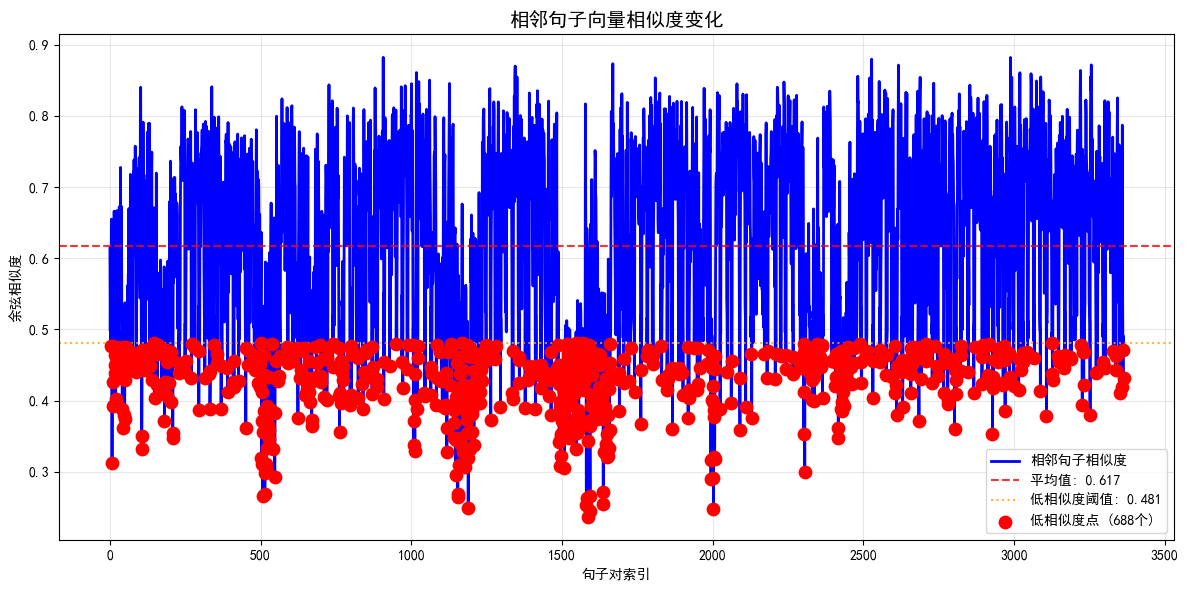


🔍 低相似度点详情:
----------------------------------------------------------------------
位置   3 | 相似度: 0.4769
  句子1: 看官，你道此书从何而起？说来虽近荒唐，细玩颇有趣味。
  句子2: 却说那女娲氏炼石补天之时，于大荒山无稽崖炼成高十二丈、见方二十四丈大的顽石三万六千五百零一块。那娲皇...
----------------------------------------------------------------------
位置   7 | 相似度: 0.3120
  句子1: 无才可去补苍天，枉入红尘若许年。
  句子2: 此系身前身后事，倩谁记去作奇传？
----------------------------------------------------------------------
位置   8 | 相似度: 0.4770
  句子1: 此系身前身后事，倩谁记去作奇传？
  句子2: 空空道人看了一回，晓得这石头有些来历，遂向石头说道：“石兄，你这一段故事，据你自己说来，有些趣味，故...
----------------------------------------------------------------------
位置  10 | 相似度: 0.4257
  句子1: 满纸荒唐言，一把辛酸泪。
  句子2: 都云作者痴，谁解其中味？
----------------------------------------------------------------------
位置  11 | 相似度: 0.3931
  句子1: 都云作者痴，谁解其中味？
  句子2: 《石头记》缘起既明，正不知那石头上面记着何人何事？看官请听。
----------------------------------------------------------------------


In [12]:
# 可视化
print("\n📊 绘制相似度图表...")
plot_pairwise_similarity(similarity_results)